In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("./data/bank-full.csv",encoding='latin1',sep=";")

In [3]:
df.head(2)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no


## Data Exploration

- Sanity Checks: Check if there are any improbably values
- Find which continous variables are related closely to the target
- Find which categorical variables are related closely to the target

### **Sanity Checks**

#### Continous variables: Sanity Checks

In [4]:
cont_variables = ['age','balance','day','duration','campaign','pdays','previous']
for var in cont_variables:
    print(var)
    print("*"*50)
    print(df[var].describe())
    print("*"*50)

age
**************************************************
count    45211.000000
mean        40.936210
std         10.618762
min         18.000000
25%         33.000000
50%         39.000000
75%         48.000000
max         95.000000
Name: age, dtype: float64
**************************************************
balance
**************************************************
count     45211.000000
mean       1362.272058
std        3044.765829
min       -8019.000000
25%          72.000000
50%         448.000000
75%        1428.000000
max      102127.000000
Name: balance, dtype: float64
**************************************************
day
**************************************************
count    45211.000000
mean        15.806419
std          8.322476
min          1.000000
25%          8.000000
50%         16.000000
75%         21.000000
max         31.000000
Name: day, dtype: float64
**************************************************
duration
**************************************************


**Comments:**

- Previous and pdays convey almost similar information
- All the other variables look ok 
- One can make a new variable which tracks if previously any contact was made with the customer

#### Continous Check Missing values

In [5]:
for var in cont_variables:
    print(f'{var}: {df[var].isnull().sum()}')

age: 0
balance: 0
day: 0
duration: 0
campaign: 0
pdays: 0
previous: 0


#### Categorical Variable: Sanity Checks

In [6]:
cat_variables = ['job','marital','education','default','housing','loan','contact','month','poutcome']

def get_dist(var):
    return df[var].value_counts(normalize=True)

for var in cat_variables:
    print("*"*50)
    print(var)
    print(get_dist(var))
    print("*"*50)

**************************************************
job
blue-collar      0.215257
management       0.209197
technician       0.168034
admin.           0.114375
services         0.091880
retired          0.050076
self-employed    0.034925
entrepreneur     0.032890
unemployed       0.028820
housemaid        0.027427
student          0.020747
unknown          0.006370
Name: job, dtype: float64
**************************************************
**************************************************
marital
married     0.601933
single      0.282896
divorced    0.115171
Name: marital, dtype: float64
**************************************************
**************************************************
education
secondary    0.513194
tertiary     0.294198
primary      0.151534
unknown      0.041074
Name: education, dtype: float64
**************************************************
**************************************************
default
no     0.981973
yes    0.018027
Name: default, dtype: float64


**Comments**

- There is nothing out of ordinary here
- Some variables such as month may not be very informative, but this needs to be checked.

### **Relationship Checks: Continous Variables**

In [7]:
def get_rel(var,q=10):
    table = pd.DataFrame()
    table[var] = df[var]
    table['target'] = df['y'].map(lambda x: 1 if x=='yes' else 0)
    table['deciles'] = pd.qcut(table[var],q=q)
    return table.groupby('deciles')['target'].mean()

In [8]:
retry = []
for var in cont_variables:
    print(var)
    print("*"*50)
    try:
        print(get_rel(var))
    except:
        retry.append(var)
    print("*"*50)

age
**************************************************
deciles
(17.999, 29.0]    0.175991
(29.0, 32.0]      0.110312
(32.0, 34.0]      0.104562
(34.0, 36.0]      0.109189
(36.0, 39.0]      0.098301
(39.0, 42.0]      0.089249
(42.0, 46.0]      0.089590
(46.0, 51.0]      0.089826
(51.0, 56.0]      0.094830
(56.0, 95.0]      0.203299
Name: target, dtype: float64
**************************************************
balance
**************************************************
deciles
(-8019.001, 0.0]      0.068956
(0.0, 22.0]           0.072194
(22.0, 131.0]         0.091769
(131.0, 272.0]        0.108282
(272.0, 448.0]        0.114127
(448.0, 701.0]        0.120080
(701.0, 1126.0]       0.126823
(1126.0, 1859.0]      0.142477
(1859.0, 3574.0]      0.166114
(3574.0, 102127.0]    0.161248
Name: target, dtype: float64
**************************************************
day
**************************************************
deciles
(0.999, 5.0]    0.147958
(5.0, 7.0]      0.090157
(7.0, 10.0]     0

**Comments**:

- There is a U shaped relationship between response to marketing and age. For the variable day the relationship looks zig-zag. While building a model, one can do a categorical transformation and check which version of the variable works
- For all the other variables, there seem to be a linear relationship
- Decile computations for the `campaign`, `pdays` and `previous` are failing, we will need to handle them separately
- For clarity lets look at the plots below

<AxesSubplot:xlabel='deciles'>

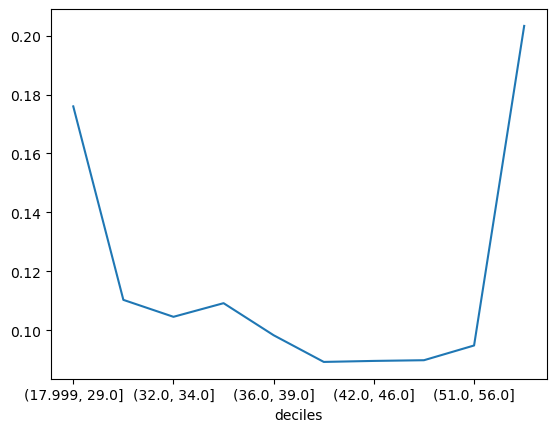

In [9]:
get_rel('age').plot()

<AxesSubplot:xlabel='deciles'>

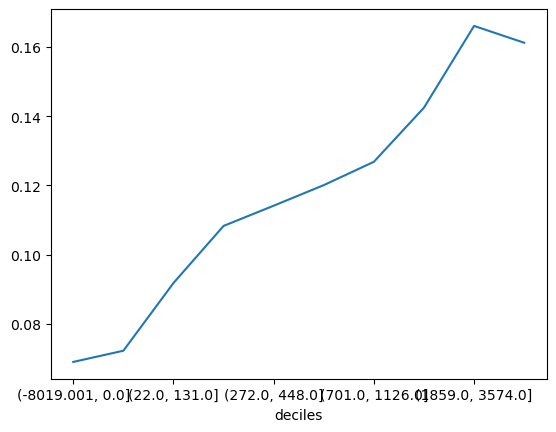

In [10]:
get_rel('balance').plot()

<AxesSubplot:xlabel='deciles'>

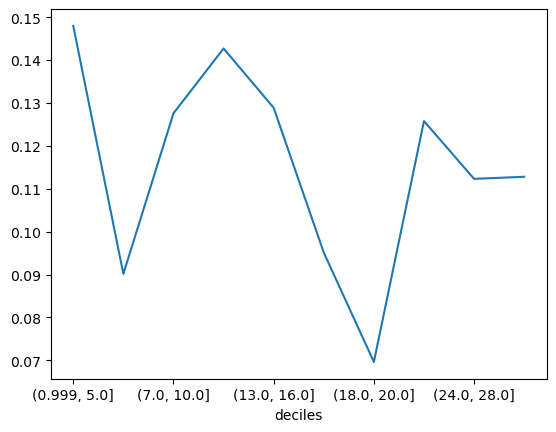

In [11]:
get_rel('day').plot()

<AxesSubplot:xlabel='deciles'>

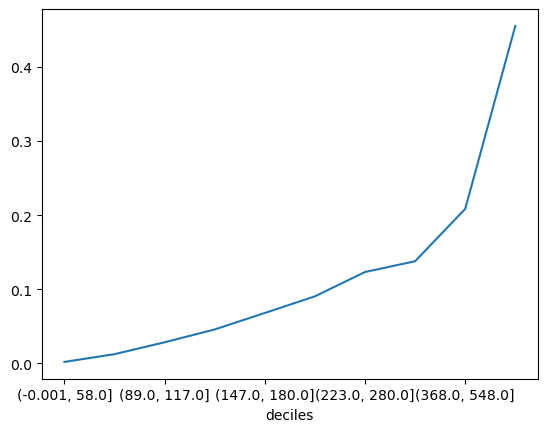

In [12]:
get_rel('duration').plot()

In [13]:
get_rel('campaign',q=2) ## we will make a dummy variable here

deciles
(0.999, 2.0]    0.131851
(2.0, 63.0]     0.087521
Name: target, dtype: float64

In [14]:
get_rel('pdays',q=1) ## can't do a decile split here, lets see what is the event rate when pdays=-1 (not contacted previously)

deciles
(-1.001, 871.0]    0.116985
Name: target, dtype: float64

In [15]:
df[df['pdays']==-1]['y'].map(lambda x: 1 if x=="yes" else 0).mean() ## very low event rate

0.09157330735509012

In [16]:
df[df['pdays']==-1]['y'].map(lambda x: 1 if x=="yes" else 0).shape[0]

36954

In [17]:
df[df['pdays']>-1]['y'].map(lambda x: 1 if x=="yes" else 0).mean() ## good event rate

0.2307133341407291

In [18]:
df[df['pdays']>-1]['y'].map(lambda x: 1 if x=="yes" else 0).shape[0]

8257

In [19]:
get_rel('previous',q=1) ## can't do decile split

deciles
(-0.001, 275.0]    0.116985
Name: target, dtype: float64

In [20]:
df[df['previous']==0]['y'].map(lambda x: 1 if x=="yes" else 0).mean() ## low event rate

0.09157330735509012

In [21]:
df[df['previous']==0]['y'].map(lambda x: 1 if x=="yes" else 0).shape[0]

36954

In [22]:
df[df['previous']>0]['y'].map(lambda x: 1 if x=="yes" else 0).mean() ## high event rate

0.2307133341407291

In [23]:
df[df['previous']>0]['y'].map(lambda x: 1 if x=="yes" else 0).shape[0]

8257

**Comments**:

- Both `previous` and `pdays` contain same information, we can create a new variable
- Create a dummy variable for `campaign` variable

### **Relationship Checks: Categorical Variables**

In [24]:
def get_rel_cat(var,q=10):
    table = pd.DataFrame()
    table[var] = df[var]
    table['target'] = df['y'].map(lambda x: 1 if x=='yes' else 0)
    return table.groupby(var).agg({'target':['mean','size']}).reset_index()

In [25]:
retry = []
for var in cat_variables:
    print(var)
    print("*"*50)
    try:
        print(get_rel_cat(var))
    except:
        retry.append(var)
    print("*"*50)

job
**************************************************
              job    target      
                       mean  size
0          admin.  0.122027  5171
1     blue-collar  0.072750  9732
2    entrepreneur  0.082717  1487
3       housemaid  0.087903  1240
4      management  0.137556  9458
5         retired  0.227915  2264
6   self-employed  0.118429  1579
7        services  0.088830  4154
8         student  0.286780   938
9      technician  0.110570  7597
10     unemployed  0.155027  1303
11        unknown  0.118056   288
**************************************************
marital
**************************************************
    marital    target       
                 mean   size
0  divorced  0.119455   5207
1   married  0.101235  27214
2    single  0.149492  12790
**************************************************
education
**************************************************
   education    target       
                  mean   size
0    primary  0.086265   6851
1  secondary

`default`, `housing` and `loan` can be converted to numeric dummies

## Feature Engineering

**Continous Variables**

In [26]:
df['campaign_dummy'] = df['campaign'].map(lambda x: 1 if x<=2 else 0)

In [27]:
df['prev_campaign_contact'] = df['pdays'].map(lambda x: 1 if x>-1 else 0)

In [28]:
df['age_dummy']=df['age'].map(lambda x: 1 if x<=42 else 0)

In [29]:
df['y'] = df['y'].map(lambda x: 1 if x=='yes' else 0)

In [30]:
df['default'] = df['default'].map(lambda x: 1 if x=='yes' else 0)
df['housing'] = df['housing'].map(lambda x: 1 if x=="yes" else 0)
df['loan'] = df['loan'].map(lambda x: 1 if x=='yes' else 0)

## Model Iterations

In [31]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y', 'campaign_dummy', 'prev_campaign_contact',
       'age_dummy'],
      dtype='object')

In [32]:
train = df.sample(frac=0.70,replace=False,random_state=42)
test = df.drop(train.index)

In [33]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

Iteration 1: All numeric and feature engineered variables

In [34]:
mod1 = smf.glm('''y~age_dummy+balance+day+duration+campaign_dummy+prev_campaign_contact+default+housing+loan''',
                   family=sm.families.Binomial(),data=train).fit()

In [35]:
print(mod1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                31648
Model:                            GLM   Df Residuals:                    31638
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8676.7
Date:                Mon, 30 Jan 2023   Deviance:                       17353.
Time:                        15:33:19   Pearson chi2:                 3.28e+06
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1604
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -3.32

**Comments**

- Signs of coeff of all variables are in line with EDA
- All the coeff are significant


Iteration 2: Add categorical variables one at a time

In [36]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y', 'campaign_dummy', 'prev_campaign_contact',
       'age_dummy'],
      dtype='object')

In [37]:
mod2 = smf.glm('''y~age_dummy+balance+day+duration+campaign_dummy+prev_campaign_contact+default+housing+loan+marital''',
                   family=sm.families.Binomial(),data=train).fit()

In [38]:
print(mod2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                31648
Model:                            GLM   Df Residuals:                    31636
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8639.9
Date:                Mon, 30 Jan 2023   Deviance:                       17280.
Time:                        15:33:19   Pearson chi2:                 3.27e+06
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1623
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -3.23

In [39]:
mod3 = smf.glm('''y~age_dummy+balance+day+duration+campaign_dummy+prev_campaign_contact+default+housing+loan+marital+education''',
                   family=sm.families.Binomial(),data=train).fit()

In [40]:
print(mod3.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                31648
Model:                            GLM   Df Residuals:                    31633
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8607.3
Date:                Mon, 30 Jan 2023   Deviance:                       17215.
Time:                        15:33:19   Pearson chi2:                 4.46e+06
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1640
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -3

**Comment: drop `age_dummy` as its no longer siginificant**

In [41]:
mod4 = smf.glm('''y~balance+day+duration+campaign_dummy+prev_campaign_contact+default+housing+loan+marital+education''',
                   family=sm.families.Binomial(),data=train).fit()
print(mod4.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                31648
Model:                            GLM   Df Residuals:                    31634
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8607.7
Date:                Mon, 30 Jan 2023   Deviance:                       17215.
Time:                        15:33:19   Pearson chi2:                 4.33e+06
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1640
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -3

In [42]:
mod5 = smf.glm('''y~balance+day+duration+campaign_dummy+prev_campaign_contact+default+housing+loan+marital+education+contact''',
                   family=sm.families.Binomial(),data=train).fit()
print(mod5.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                31648
Model:                            GLM   Df Residuals:                    31632
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8447.0
Date:                Mon, 30 Jan 2023   Deviance:                       16894.
Time:                        15:33:19   Pearson chi2:                 6.98e+06
No. Iterations:                     7   Pseudo R-squ. (CS):             0.1725
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -3

**Comment: Remove `contact`**

In [43]:
mod6 = smf.glm('''y~balance+day+duration+campaign_dummy+prev_campaign_contact+default+housing+loan+marital+education+job''',
                   family=sm.families.Binomial(),data=train).fit()
print(mod6.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                31648
Model:                            GLM   Df Residuals:                    31623
Model Family:                Binomial   Df Model:                           24
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8514.7
Date:                Mon, 30 Jan 2023   Deviance:                       17029.
Time:                        15:33:20   Pearson chi2:                 5.68e+06
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1689
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -3

**Comment**: Remove level `marital[married]` and `job[unemployed]`

In [44]:
train['single_dummy'] = train['marital'].map(lambda x: 1 if x=='single' else 0)
test['single_dummy'] = test['marital'].map(lambda x: 1 if x=='single' else 0)
for level in train['job'].unique():
    if level!='unknown' or level!='unemployed':
        train[level.replace("-","_").replace(".","")+"_dummy"] = train['job'].map(lambda x: 1 if x==level else 0)
        test[level.replace("-","_").replace(".","")+"_dummy"] = test['job'].map(lambda x: 1 if x==level else 0)
        

In [45]:
train.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y', 'campaign_dummy', 'prev_campaign_contact',
       'age_dummy', 'single_dummy', 'blue_collar_dummy', 'services_dummy',
       'student_dummy', 'management_dummy', 'admin_dummy', 'technician_dummy',
       'self_employed_dummy', 'entrepreneur_dummy', 'retired_dummy',
       'unemployed_dummy', 'housemaid_dummy', 'unknown_dummy'],
      dtype='object')

In [46]:
mod7 = smf.glm('''y~balance+day+duration+campaign_dummy+prev_campaign_contact+default+housing+loan+education+single_dummy+
                blue_collar_dummy+services_dummy+student_dummy+management_dummy+technician_dummy+self_employed_dummy+entrepreneur_dummy+retired_dummy''',
                   family=sm.families.Binomial(),data=train).fit()
print(mod7.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                31648
Model:                            GLM   Df Residuals:                    31627
Model Family:                Binomial   Df Model:                           20
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8523.5
Date:                Mon, 30 Jan 2023   Deviance:                       17047.
Time:                        15:33:20   Pearson chi2:                 5.51e+06
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1684
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -3

**Comment**: Remove `technician_dummy` and `default`

In [47]:
mod8 = smf.glm('''y~balance+day+duration+campaign_dummy+prev_campaign_contact+housing+loan+education+single_dummy+
                blue_collar_dummy+services_dummy+student_dummy+management_dummy+self_employed_dummy+entrepreneur_dummy+retired_dummy''',
                   family=sm.families.Binomial(),data=train).fit()
print(mod8.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                31648
Model:                            GLM   Df Residuals:                    31629
Model Family:                Binomial   Df Model:                           18
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8525.7
Date:                Mon, 30 Jan 2023   Deviance:                       17051.
Time:                        15:33:20   Pearson chi2:                 5.80e+06
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1683
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -3

**Comment**: The above model is finalized as all the coefficients are significant

In [48]:
from sklearn.metrics import confusion_matrix,roc_auc_score

In [49]:
train['y'].mean()

0.11732178968655207

In [50]:
pred_scores = mod8.predict(test)
pred_labels = pred_scores.map(lambda x: 1 if x>=0.11732178968655207 else 0)

In [51]:
confusion_matrix(test['y'],pred_labels)

array([[9619, 2368],
       [ 327, 1249]])

In [52]:
roc_auc_score(test['y'],pred_scores)

0.8732853675237853